## A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import warnings
import magec_utils as mg
%matplotlib inline
warnings.filterwarnings('ignore') 

Using TensorFlow backend.


### PIMA Dataset
The Pima are a group of Native Americans living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, the PIMA have undergone of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity. The Pima have been under near-constant study since 1965 due to the high incidence rate of Diabetes in PIMA females. The dataset was originally published by the National Institute of Diabetes and Digestive and Kidney Diseases, consisting of 8 diagnostic measurements pertaining to 768 females of age greater than 20.(Smith et al, 1988) and a binary target variable marking whether that woman developed type 2 diabetes within the next 5 years. Three types of models: logistic regression, a random forest, and a deep neural network were trained on the data with two goals. First, to provide a simple dataset with which to access the fidelity of the MAGECS. Second, to directly compare any differences that these three statistical models might learn when trained on the same data!

In [2]:
pima, stsc, x_train_p, x_validation_p, y_train_p, y_validation_p = mg.pima_data()

### PIMA Exploratory Data Analysis (EDA)

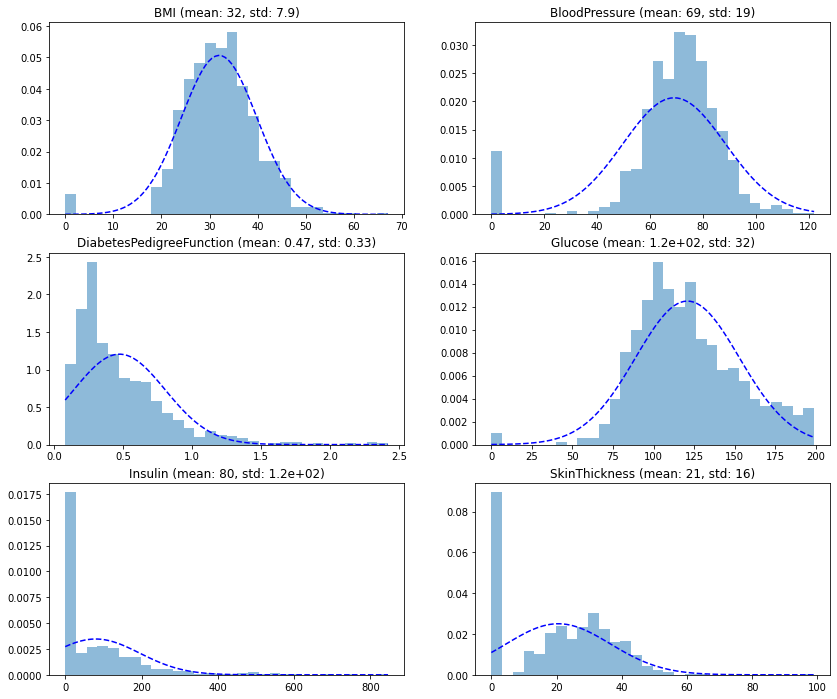

In [3]:
mg.plot_pima_features(pima);

## PIMA ML Models

In [4]:
models = mg.pima_models(x_train_p, y_train_p)

In [5]:
mlp = models['mlp']
rf = models['rf']
lr = models['lr']
ensemble = models['ensemble']

In [6]:
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc = mg.evaluate(mlp, x_validation_p, y_validation_p)

Accuracy: 0.792208
Precision: 0.745098
Recall: 0.666667
F1 score: 0.703704
ROC AUC: 0.852595
[[84 13]
 [19 38]]


In [7]:
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc = mg.evaluate(rf, x_validation_p, y_validation_p)

Accuracy: 0.792208
Precision: 0.755102
Recall: 0.649123
F1 score: 0.698113
ROC AUC: 0.861458
[[85 12]
 [20 37]]


In [8]:
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc = mg.evaluate(lr, x_validation_p, y_validation_p)

Accuracy: 0.772727
Precision: 0.739130
Recall: 0.596491
F1 score: 0.660194
ROC AUC: 0.865437
[[85 12]
 [23 34]]


In [9]:
ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1, ensemble_auc = \
    mg.evaluate(ensemble, x_validation_p, y_validation_p)

Accuracy: 0.792208
Precision: 0.755102
Recall: 0.649123
F1 score: 0.698113
ROC AUC: 0.873757
[[85 12]
 [20 37]]


## MAgECs

In [10]:
# MLP
case_mlp = mg.case_magecs(mlp, x_validation_p, model_name='mlp')
magecs_mlp = mg.normalize_magecs(case_mlp, features=None, model_name='mlp')
magecs_mlp = magecs_mlp.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# RF
case_rf = mg.case_magecs(rf, x_validation_p, model_name='rf')
magecs_rf = mg.normalize_magecs(case_rf, features=None, model_name='rf')
magecs_rf = magecs_rf.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# LR
case_lr = mg.case_magecs(lr, x_validation_p, model_name='lr')
magecs_lr = mg.normalize_magecs(case_lr, features=None, model_name='lr')
magecs_lr = magecs_lr.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# ENSEMBLE
case_en = mg.case_magecs(ensemble, x_validation_p, model_name='en')
magecs_en = mg.normalize_magecs(case_en, features=None, model_name='en')
magecs_en = magecs_en.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [11]:
features = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

In [12]:
joined = mg.magec_models(magecs_mlp, 
                         magecs_rf, 
                         magecs_lr, 
                         magecs_en,
                         Xdata=x_validation_p, 
                         Ydata=y_validation_p, 
                         features=features)

### MAgEC Rank-Biased-Overlap

In [13]:
weights_auc = {'mlp': mlp_auc, 'rf': rf_auc, 'lr': lr_auc}
weights_recall = {'mlp': mlp_recall, 'rf': rf_recall, 'lr': lr_recall}
models = ('mlp', 'rf', 'lr')
ranks = mg.magec_rank(joined, rank=len(features), features=features)
consensus_auc = mg.magec_consensus(ranks, use_weights=True, weights=weights_auc, models=models)
consensus_recall = mg.magec_consensus(ranks, use_weights=True, weights=weights_recall, models=models)
rbos = mg.magec_rbos(ranks, models=models)

## Panel plots

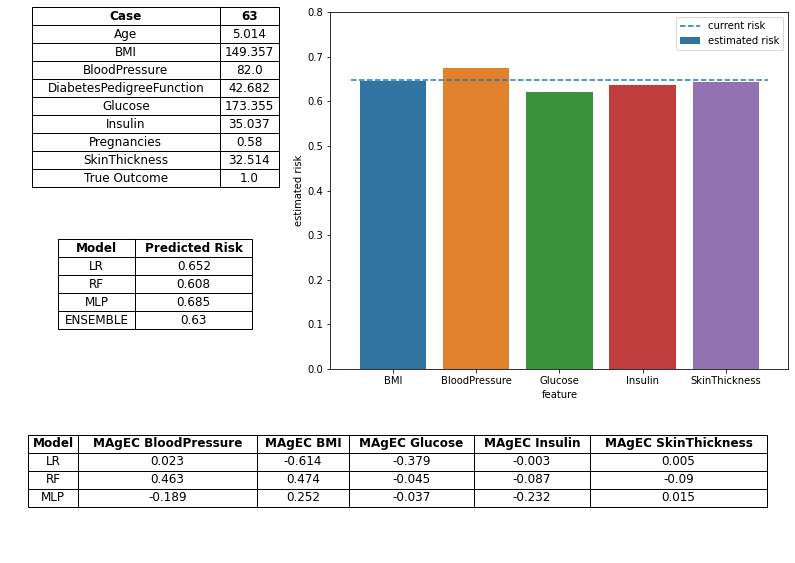

In [14]:
case = 63
mg.panel_plot(x_train_p.columns, features, stsc, joined, consensus_auc, case)